In [1]:
import os
import pickle

import tensorflow as tf
from keras.callbacks import *

from dataloader import *
from model import *
from mymetrics import *

import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
'''
訓練跟驗證集的圖像與標籤資料增生
可以將trainGenerator函式中save_to_dir改到自己指定資料夾, 就能看到增生的圖像與標籤
例如 save_to_dir=r'data\membrane\train\aug'
'''

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

myGene = trainGenerator(16, 'data/membrane/train', 'image', 'label', data_gen_args, save_to_dir=None)

val_aug_dict = {'rescale': 1./255}

valGene = trainGenerator(16, 'data/membrane/val', 'val_image', 'val_label', val_aug_dict,
                         image_color_mode="grayscale", mask_color_mode="grayscale",
                         image_save_prefix="val_image", mask_save_prefix="val_label",
                         save_to_dir=None, target_size=(256, 256), seed=1)

In [4]:
model = ResUNet_Attention()

#打印模型結構
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256, 1)  0           ['batch_normalization[0][0]']    
                                                                                              

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=dice_loss, metrics=[IOU_coefficient, dice_coefficient, 'accuracy'])

model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='loss', verbose=1, save_best_only=True)

#每個時期迭代次數 = 資料夾圖片總數 / 訓練批次(batch_size)
history = model.fit(myGene, epochs=100, steps_per_epoch=86, validation_data=valGene, validation_steps=25,
                    callbacks=[model_checkpoint])

Found 1370 images belonging to 1 classes.
Found 1370 images belonging to 1 classes.
Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 0.1088 - IOU_coefficient: 0.8094 - dice_coefficient: 0.8915 - accuracy: 0.8557Found 390 images belonging to 1 classes.
Found 390 images belonging to 1 classes.

Epoch 1: loss improved from inf to 0.10882, saving model to best_model.hdf5
86/86 [==============================] - 35s 330ms/step - loss: 0.1088 - IOU_coefficient: 0.8094 - dice_coefficient: 0.8915 - accuracy: 0.8557 - val_loss: 0.1734 - val_IOU_coefficient: 0.7044 - val_dice_coefficient: 0.8265 - val_accuracy: 0.7974
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 0.0486 - IOU_coefficient: 0.9074 - dice_coefficient: 0.9514 - accuracy: 0.9280
Epoch 2: loss improved from 0.10882 to 0.04859, saving model to best_model.hdf5
86/86 [==============================] - 27s 313ms/step - loss: 0.0486 - IOU_coefficient: 0.9074 - dice_coefficient: 0.9514 - accuracy: 

In [6]:
#保存訓練指標
with open("trainHistory.txt", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

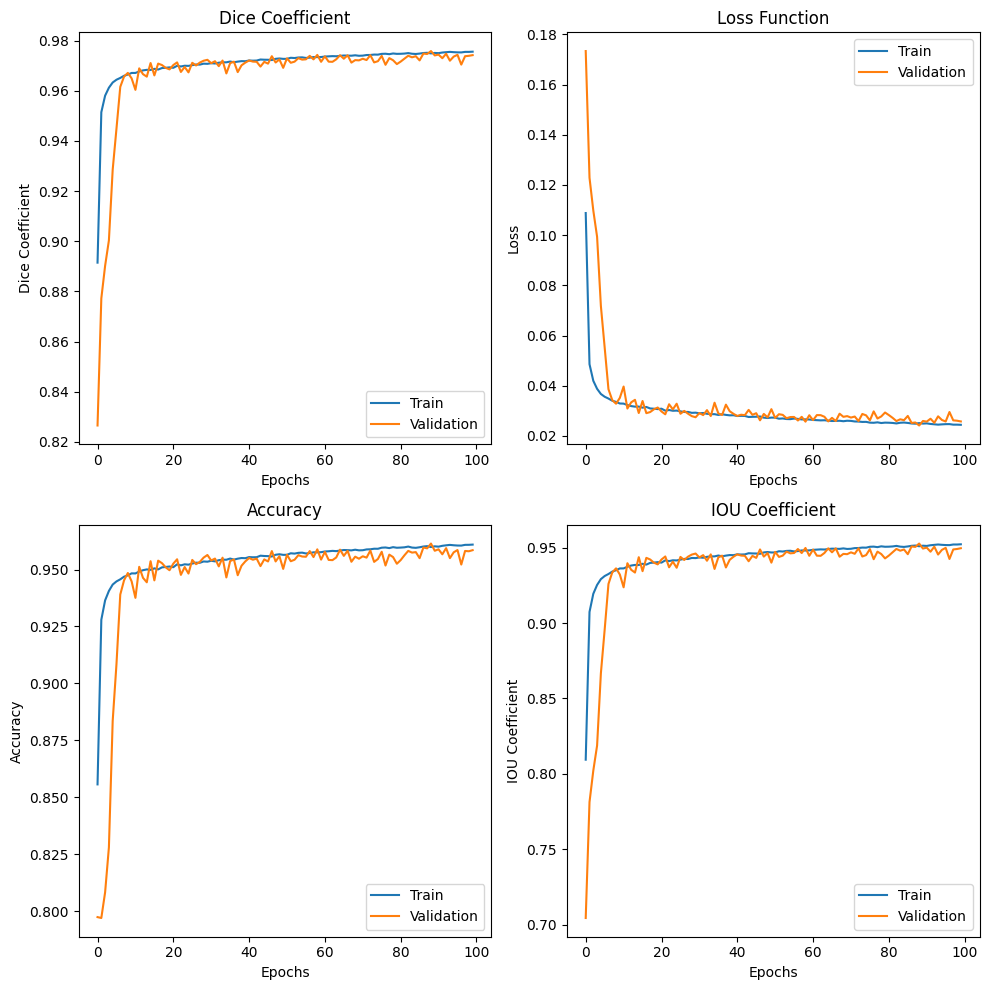

In [7]:
#訓練指標視覺化
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history.history['dice_coefficient'], label='Train')
axs[0, 0].plot(history.history['val_dice_coefficient'], label='Validation')
axs[0, 0].set_title('Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coefficient')
axs[0, 0].legend()

axs[0, 1].plot(history.history['loss'], label='Train')
axs[0, 1].plot(history.history['val_loss'], label='Validation')
axs[0, 1].set_title('Loss Function')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

axs[1, 0].plot(history.history['accuracy'], label='Train')
axs[1, 0].plot(history.history['val_accuracy'], label='Validation')
axs[1, 0].set_title('Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

axs[1, 1].plot(history.history['IOU_coefficient'], label='Train')
axs[1, 1].plot(history.history['val_IOU_coefficient'], label='Validation')
axs[1, 1].set_title('IOU Coefficient')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IOU Coefficient')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [8]:
#用訓練好的模型預測測試集圖像
testGene = testGenerator(r"D:\unet_ours\data\membrane\test")
model.load_weights("best_model.hdf5")
results = model.predict(testGene, 200, verbose=1)
saveResult(r"D:\unet_ours\data\membrane\test", results)

200/200 [==============================] - 3s 11ms/step
